# **EXPERIMENT A**

## *1. Installs:*

In [ ]:
# Pip installs:
!pip install kaggle
!pip install focal-loss
!pip install vit-keras
!pip install tensorflow_addons
!pip install tfswin
!pip install keras-tuner --upgrade

In [ ]:
# Library installs:
import os
import gc
import cv2
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import PIL
from PIL import Image
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras_tuner
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Conv2D, Reshape, Lambda, Concatenate, Average
from keras.models import Model
from keras.applications import EfficientNetV2M, ConvNeXtBase
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BackupAndRestore, LearningRateScheduler
from keras.callbacks import Callback
from tensorflow.keras.utils import plot_model 
from keras import metrics
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from focal_loss import BinaryFocalLoss
from keras import backend as K
from vit_keras import vit
from tfswin import SwinTransformerBase224

import warnings
warnings.filterwarnings('ignore')

## *2. Importing Dataset:*

### 2.1 Global GPU policy:

In [3]:
# Defining global policy to speed up computations:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else: 
  policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

### 2.2 Downloading HPA dataset:

In [ ]:
# Connecting to Google Drive:
# drive.mount('/content/drive')

In [4]:
# Creating Kaggle directory:
!mkdir -p ~/.kaggle

In [5]:
# Moving Kaggle API credentials to Kaggle directory:
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [6]:
# Retrieving permission:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the dataset:
!kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
# Unzipping dataset:
!unzip human-protein-atlas-image-classification.zip

### 2.3 Loading dataset information:

In [9]:
# Defining constants, seed & paths:
epochs = 30
batch_size = 32
SIZE = (224, 224, 3)

seed = 123

path_to_images = '/content/train' # contains 31.072 images, distributed over 4 filter channels.
data = pd.read_csv('/content/train.csv') # contains 31.072 image IDs and labels.

In [10]:
# Checking the labels:
print(data.head())
print(len(data))

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
31072


In [11]:
# Count number of images & check:
lst = os.listdir(path_to_images)
number_images = len(lst)
print(number_images)
print((number_images / 4) == len(data))

124288
True


In [12]:
# Acquiring dataset information:
dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    dataset_info.append({
        'path':os.path.join(path_to_images, name),
        'labels':np.array([int(label) for label in labels])})
dataset_info = np.array(dataset_info)

In [13]:
# Getting image sample:
print(dataset_info[0])

{'path': '/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])}


In [14]:
# Extracting individual directories from sample:
print(dataset_info[0]['path'])
print(dataset_info[0]['labels'])

/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
[16  0]


## *3. Pre-processing:*

### 3.1 Train, validation & test set split:

In [15]:
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

indexes = np.arange(dataset_info.shape[0])
np.random.shuffle(indexes)

# Splitting the data into a train set and temporary set:
train_indexes, temp_indexes = train_test_split(indexes,
                                               test_size = 0.2,
                                               random_state = seed)

# Splitting the temporary set further into a validation & test set:
val_indexes, test_indexes = train_test_split(temp_indexes,
                                             test_size = 0.5,
                                             random_state = seed)

# Concatenating the training and validation set for training the final models:
final_train_indexes = np.concatenate((train_indexes, val_indexes))

In [16]:
# Checking the proportions:
print(train_indexes.shape,
      val_indexes.shape,
      test_indexes.shape,
      final_train_indexes.shape)

(24857,) (3107,) (3108,) (27964,)


### 3.2 Creating data generator:

In [17]:
# Custom data generator function, including reshaping, normalization & augmentation:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, aug = True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if aug:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path + '_red.png')
        image_yellow_ch = Image.open(path + '_yellow.png')
        image_green_ch = Image.open(path + '_green.png')
        image_blue_ch = Image.open(path + '_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(shear = (-10, 10)),
                iaa.Affine(rotate = 0),
                iaa.Affine(rotate = 90),
                iaa.Affine(rotate = 180),
                iaa.Affine(rotate = 270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order = True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [18]:
# Creating train, validation and test data generator:
train_generator = data_generator.create_train(
    dataset_info[train_indexes],
    batch_size,
    SIZE,
    aug = False) # Set to false in this experiment!

validation_generator = data_generator.create_train(
    dataset_info[val_indexes],
    batch_size,
    SIZE,
    aug = False)

test_generator = data_generator.create_train(
    dataset_info[test_indexes],
    batch_size,
    SIZE,
    aug = False)

In [19]:
# Creating final train generator to train final models after hyperparameter tuning:
final_train_generator = data_generator.create_train(
    dataset_info[final_train_indexes],
    batch_size,
    SIZE,
    aug = False) # Set to false in this experiment!

## *4. Hyperparameter Tuning:*

In [ ]:
# Defining EarlyStopping, ReduceLROnPlateau & BackupAndRestore for tuning:
hp_early_stopping = EarlyStopping(monitor = 'val_loss',
                                  mode = 'min',
                                  patience = 4)

hp_reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.1,
                                patience = 2,
                                verbose = 0,
                                mode = 'auto',
                                min_lr = 1e-4)

hp_restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/NORMAL/backup',
                              save_freq = 'epoch',
                              delete_checkpoint = True)

In [ ]:
# Custom callback against memory leakage:
class ClearMemory(Callback):
  def on_epoch_end(self, epoch, logs = None):
    gc.collect()
    K.clear_session()

In [ ]:
# Creating callback list:
hp_callbacks_list = [hp_early_stopping,
                     hp_reduceLR,
                     hp_restore,
                     ClearMemory()]

### 4.1 EfficientNet-V2M:

In [ ]:
# Defining the EfficientNet-V2M hyperparameter tuning model function:
def create_efficientnet_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = EfficientNetV2M(include_top = False,
                               weights = 'imagenet',
                               input_shape = SIZE)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the EfficientNet-V2M tuner:
efficientnet_tuner = keras_tuner.BayesianOptimization(create_efficientnet_hp,
                                                      objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                                      max_trials = 7,
                                                      seed = seed)

In [ ]:
# Summarizing the EfficientNet-V2M tuner:
efficientnet_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the EfficientNet-V2M model:
efficientnet_hp_start_time = time.time()

efficientnet_tuner.search(train_generator,
                          steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                          epochs = 20,
                          validation_data = validation_generator,
                          validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                          verbose = 1,
                          callbacks = hp_callbacks_list)

efficientnet_hp_end_time = time.time()

Trial 7 Complete [01h 24m 00s]
val_recall: 0.2695856988430023

Best val_recall So Far: 0.3251582384109497
Total elapsed time: 09h 33m 54s


In [ ]:
# Total time taken to tune EfficientNet-V2M model:
print("Time taken:", efficientnet_hp_end_time - efficientnet_hp_start_time, "seconds.")

Time taken: 34434.492023706436 seconds.


In [ ]:
# Extracting best hyperparameters EfficientNet-V2M model:
efficientnet_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.3251582384109497

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.31005311012268066

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.3074491322040558

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.2826896607875824

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.2695856988430023

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.2663729190826416

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.2460712194442749


### 4.2 ConvNeXt-B:

In [ ]:
# Defining the ConvNeXt-B hyperparameter tuning model function:
def create_convnext_hp(hp):
  inputs = Input(shape = SIZE)
  policyConfig = 'float32'
  prev_policy = tf.keras.mixed_precision.global_policy()
  tf.keras.mixed_precision.set_global_policy(policyConfig) # Add this, to make it compatible with global policy!
  pretrained = ConvNeXtBase(include_top = False,
                               weights = 'imagenet',
                               input_shape = SIZE)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the ConvNeXt-B tuner:
convnext_tuner = keras_tuner.BayesianOptimization(create_convnext_hp,
                                                  objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                                  max_trials = 7,
                                                  seed = seed)

In [ ]:
# Summarizing the ConvNeXt-B tuner:
convnext_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the ConvNeXt-B model:
convnext_hp_start_time = time.time()

convnext_tuner.search(train_generator,
                      steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                      epochs = 20,
                      validation_data = validation_generator,
                      validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                      verbose = 1,
                      callbacks = hp_callbacks_list)

convnext_hp_end_time = time.time()

Trial 7 Complete [01h 20m 33s]
val_recall: 0.330427885055542

Best val_recall So Far: 0.3765847980976105
Total elapsed time: 07h 28m 31s


In [ ]:
# Total time taken to tune ConvNext-B model:
print("Time taken:", convnext_hp_end_time - convnext_hp_start_time, "seconds.")

Time taken: 26911.496937274933 seconds.


In [ ]:
# Extracting best hyperparameters ConvNeXt-B model:
convnext_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.3765847980976105

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.35389482975006104

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.34331613779067993

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.34071749448776245

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.3383399248123169

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.330427885055542

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.27858132123947144


### 4.3 ViT-B16:

In [ ]:
# Defining the ViT-B16 hyperparameter tuning model function:
def create_vit_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = vit.vit_b16(include_top = False,
                           pretrained = True,
                           pretrained_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the ViT-B16 tuner:
vit_tuner = keras_tuner.BayesianOptimization(create_vit_hp,
                                             objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                             max_trials = 7,
                                             seed = seed)

In [ ]:
# Summarizing the ViT-B16 tuner:
vit_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the ViT-B16 model:
vit_hp_start_time = time.time()

vit_tuner.search(train_generator,
                 steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                 epochs = 20,
                 validation_data = validation_generator,
                 validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                 verbose = 1,
                 callbacks = hp_callbacks_list)

vit_hp_end_time = time.time()

Trial 7 Complete [01h 02m 17s]
val_recall: 0.29932647943496704

Best val_recall So Far: 0.35098424553871155
Total elapsed time: 08h 25m 20s


In [ ]:
# Total time taken to tune ViT-B16 model:
print("Time taken:", vit_hp_end_time - vit_hp_start_time, "seconds.")

Time taken: 30319.661225795746 seconds.


In [ ]:
# Extracting best hyperparameters ViT-B16 model:
vit_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.35098424553871155

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.3030061721801758

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.29932647943496704

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.28531911969184875

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.25515055656433105

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.24073711037635803

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.23113393783569336


### 4.4 Swin-B Transformer:

In [ ]:
# Defining the Swin-B Transformer hyperparameter tuning model function:
def create_swin_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = SwinTransformerBase224(include_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the Swin-B Transformer tuner:
swin_tuner = keras_tuner.BayesianOptimization(create_swin_hp,
                                              objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                              max_trials = 7,
                                              seed = seed)

In [ ]:
# Summarizing the Swin-B Transformer tuner:
swin_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the Swin-B Transformer model:
swin_hp_start_time = time.time()

swin_tuner.search(train_generator,
                  steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                  epochs = 20,
                  validation_data = validation_generator,
                  validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                  verbose = 1,
                  callbacks = hp_callbacks_list)

swin_hp_end_time = time.time()

Trial 7 Complete [01h 27m 58s]
val_recall: 0.24352331459522247

Best val_recall So Far: 0.2966752052307129
Total elapsed time: 10h 16m 47s


In [ ]:
# Total time taken to tune Swin-B Transformer model:
print("Time taken:", swin_hp_end_time - swin_hp_start_time, "seconds.")

Time taken: 37006.622562646866 seconds.


In [ ]:
# Extracting best hyperparameters Swin-B Transformer model:
swin_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.2966752052307129

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.2842710018157959

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.267527312040329

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.2573367953300476

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.25024884939193726

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.24352331459522247

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.2108924686908722


## *5. Creating Models:*

### 5.1 EfficientNet-V2M:

In [ ]:
# Defining the EfficientNet-V2M model function:
def create_efficientnet(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = EfficientNetV2M(include_top = False,
                               weights = 'imagenet',
                               input_shape = input_shape)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(256,
            activation = 'gelu')(x)
  x = Dropout(0.4)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the EfficientNet-V2M model:
efficientnet_model = create_efficientnet(input_shape = SIZE,
                                         neurons_out = 28)

In [ ]:
# Summarizing the EfficientNet-V2M model:
efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          40992     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dropout (Dropout)           (None, 1568)              0     

### 5.2 ConvNeXt-B:

In [20]:
# Defining the ConvNeXt-B model function:
def create_convnext(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  policyConfig = 'float32'
  prev_policy = tf.keras.mixed_precision.global_policy()
  tf.keras.mixed_precision.set_global_policy(policyConfig) # Add this, to make it compatible with global policy!
  pretrained = ConvNeXtBase(include_top = False,
                            weights = 'imagenet',
                            input_shape = input_shape)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(256,
            activation = 'gelu')(x)
  x = Dropout(0.4)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the ConvNeXt-B model:
convnext_model = create_convnext(input_shape = SIZE,
                                 neurons_out = 28)

In [ ]:
# Summarizing the ConvNeXt-B model:
convnext_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          32800     
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1568)              0         
                                                           

### 5.3 ViT-B16:

In [22]:
# Defining the ViT-B16 model function:
def create_vit(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = vit.vit_b16(include_top = False,
                           pretrained = True,
                           pretrained_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn) # No Conv2D layer, due to fixed outputs of ViT-B16 pre-trained model!
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(512,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the ViT-B16 model:
vit_model = create_vit(input_shape = SIZE,
                       neurons_out = 28)

In [ ]:
# Summarizing the ViT-B16 model:
vit_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dropout_4 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               393728    
                                                           

### 5.4 Swin-B Transformer:

In [ ]:
# Defining the Swin-B Transformer model function:
def create_swin(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = SwinTransformerBase224(include_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(512,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the Swin-B Transformer model:
swin_model = create_swin(input_shape = SIZE,
                         neurons_out = 28)

In [ ]:
# Summarizing the Swin-B Transformer model:
swin_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 swin_base_224 (Functional)  (None, None, None, 1024)  86743224  
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          32800     
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1568)              0         
                                                           

### 5.5 Ensemble Model:

In [ ]:
# Loading the base models:
convnext_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ConvNeXt-B.h5')
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
vit_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ViT-B16.h5')
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [24]:
# Loading the fine-tuned models:
convnext_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ConvNeXt-B.h5')
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [25]:
vit_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ViT-B16.h5')
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

####5.5.1 Average Ensemble:

In [ ]:
# Defining the average ensemble model function with base models:
def create_average_ensemble_base_A(input_shape, neurons_out):
  models = [convnext_model,
            vit_model]
  input = Input(shape = input_shape)
  outputs = [model(input) for model in models]
  output = Average()(outputs)
  ensemble_model = Model(input, output)
  return ensemble_model

In [ ]:
# Creating the average ensemble model:
average_ensemble_base_A = create_average_ensemble_base_A(input_shape = SIZE,
                                                         neurons_out = 28)

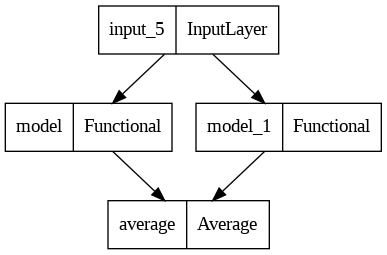

In [ ]:
# Illustrating the model:
plot_model(average_ensemble_base_A)

In [26]:
# Defining the average ensemble model function with fine-tuned models:
def create_average_ensemble_fine_A(input_shape, neurons_out):
  models = [convnext_model,
            vit_model]
  input = Input(shape = input_shape)
  outputs = [model(input) for model in models]
  output = Average()(outputs)
  ensemble_model = Model(input, output)
  return ensemble_model

In [27]:
# Creating the average ensemble model:
average_ensemble_fine_A = create_average_ensemble_fine_A(input_shape = SIZE,
                                                         neurons_out = 28)

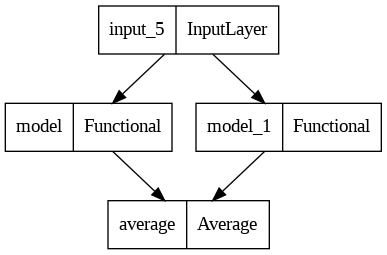

In [ ]:
# Illustrating the model:
plot_model(average_ensemble_fine_A)

## *6. Model Training & Evaluation:*

In [ ]:
# Defining LearningRateScheduler:
def scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return 0.0001

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Defining BackupAndRestore:
restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/NORMAL/backup',
                           save_freq = 'epoch',
                           delete_checkpoint = True)

In [ ]:
# Creating callback list:
callbacks_list = [restore,
                  lr_scheduler]

In [ ]:
# History plot function:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history['loss'], label = 'Train loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label = 'Test loss')
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history['binary_accuracy'], label = 'Train accuracy')
    ax[1].plot(history.epoch, history.history['val_binary_accuracy'], label = 'Test accuracy')
    ax[0].legend()
    ax[1].legend()

### 6.1 EfficientNet-V2M:

In [ ]:
# Compiling the EfficientNet-V2M model:
efficientnet_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the EfficientNet-V2M model:
efficientnet_start_time = time.time()

efficientnet_history = efficientnet_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

efficientnet_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 314s 317ms/step - loss: 0.0515 - binary_accuracy: 0.9393 - precision: 0.4221 - recall: 0.1099 - auc: 0.5427 - val_loss: 0.0463 - val_binary_accuracy: 0.9447 - val_precision: 0.6830 - val_recall: 0.1191 - val_auc: 0.6037 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 270s 309ms/step - loss: 0.0468 - binary_accuracy: 0.9445 - precision: 0.6031 - recall: 0.1415 - auc: 0.5933 - val_loss: 0.0446 - val_binary_accuracy: 0.9459 - val_precision: 0.7160 - val_recall: 0.1392 - val_auc: 0.6214 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 269s 309ms/step - loss: 0.0456 - binary_accuracy: 0.9455 - precision: 0.6215 - recall: 0.1676 - auc: 0.6325 - val_loss: 0.0439 - val_binary_accuracy: 0.9463 - val_precision: 0.7500 - val_recall: 0.1370 - val_auc: 0.6614 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 269s 308ms/step - loss: 0.0445 - binary_accuracy: 0.9468 - precision: 0.6480 - recall

In [ ]:
# Saving the EfficientNet-V2M model:
efficientnet_model.save('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-EfficientNet-V2M.h5')

In [ ]:
# Total time taken to train EfficientNet-V2M model:
print("Time taken:", efficientnet_end_time - efficientnet_start_time, "seconds.")

Time taken: 8120.7034113407135 seconds.


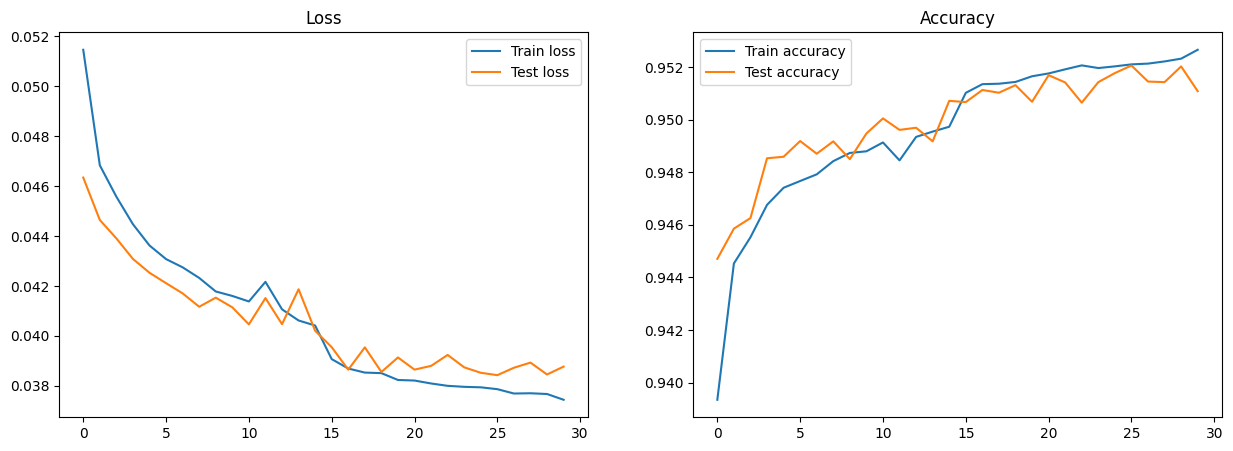

In [ ]:
# EfficientNet_V2M model train & test history plot:
show_history(efficientnet_history)

In [ ]:
# Evaluating the EfficientNet-V2M model:
efficientnet_evaluate = efficientnet_model.evaluate(test_generator,
                                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                    verbose = 1)

98/98 [==============================] - 27s 275ms/step - loss: 0.0384 - binary_accuracy: 0.9520 - precision: 0.7078 - recall: 0.3146 - auc: 0.7835


In [ ]:
# Extracting EfficientNet_V2M model metrics:
efficientnet_test_accuracy, efficientnet_test_precision, efficientnet_test_recall, efficientnet_test_auc = efficientnet_evaluate[1:]
efficientnet_test_f1 = 2 * (efficientnet_test_precision * efficientnet_test_recall) / (efficientnet_test_precision + efficientnet_test_recall)

print('EfficientNet_V2M Test Accuracy:', efficientnet_test_accuracy)
print('EfficientNet_V2M Test AUC-score:', efficientnet_test_auc)
print('EfficientNet_V2M Test F1-score:', efficientnet_test_f1)
print('EfficientNet_V2M Test Precision:', efficientnet_test_precision)
print('EfficientNet_V2M Test Recall:', efficientnet_test_recall)

EfficientNet_V2M Test Accuracy: 0.9520362615585327
EfficientNet_V2M Test AUC-score: 0.7835260033607483
EfficientNet_V2M Test F1-score: 0.43564089372924253
EfficientNet_V2M Test Precision: 0.70782071352005
EfficientNet_V2M Test Recall: 0.31464844942092896


### 6.2 ConvNeXt-B:

In [ ]:
# Compiling the ConvNeXt-B model:
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ConvNeXt-B model:
convnext_start_time = time.time()

convnext_history = convnext_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

convnext_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 346s 340ms/step - loss: 0.0505 - binary_accuracy: 0.9403 - precision: 0.4629 - recall: 0.1504 - auc: 0.6008 - val_loss: 0.0430 - val_binary_accuracy: 0.9466 - val_precision: 0.7388 - val_recall: 0.1481 - val_auc: 0.6706 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 270s 309ms/step - loss: 0.0429 - binary_accuracy: 0.9477 - precision: 0.6435 - recall: 0.2292 - auc: 0.7001 - val_loss: 0.0409 - val_binary_accuracy: 0.9493 - val_precision: 0.7063 - val_recall: 0.2449 - val_auc: 0.7097 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 269s 308ms/step - loss: 0.0412 - binary_accuracy: 0.9492 - precision: 0.6623 - recall: 0.2627 - auc: 0.7441 - val_loss: 0.0405 - val_binary_accuracy: 0.9497 - val_precision: 0.7254 - val_recall: 0.2401 - val_auc: 0.7278 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 269s 308ms/step - loss: 0.0403 - binary_accuracy: 0.9499 - precision: 0.6696 - recall

In [ ]:
# Saving the ConvNeXt-B model:
convnext_model.save('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ConvNeXt-B.h5')

In [ ]:
# Total time taken to train ConvNeXt-B model:
print("Time taken:", convnext_end_time - convnext_start_time, "seconds.")

Time taken: 8272.563378572464 seconds.


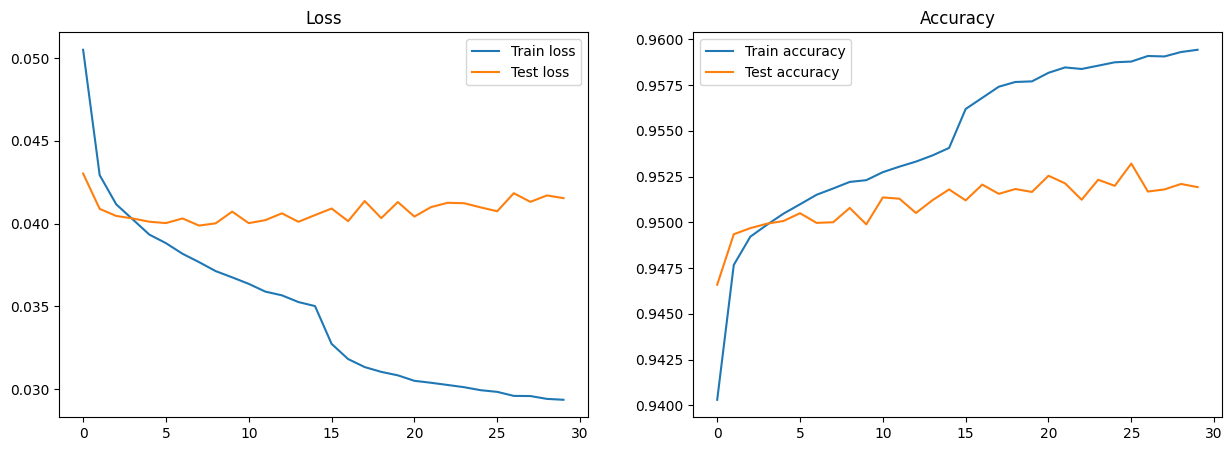

In [ ]:
# ConvNeXt-B model train & test history plot:
show_history(convnext_history)

In [ ]:
# Evaluating the ConvNeXt-B model:
convnext_evaluate = convnext_model.evaluate(test_generator,
                                            steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                            verbose = 1)

98/98 [==============================] - 27s 280ms/step - loss: 0.0413 - binary_accuracy: 0.9523 - precision: 0.6819 - recall: 0.3547 - auc: 0.7374


In [ ]:
# Extracting ConvNeXt-B model metrics:
convnext_test_accuracy, convnext_test_precision, convnext_test_recall, convnext_test_auc = convnext_evaluate[1:]
convnext_test_f1 = 2 * (convnext_test_precision * convnext_test_recall) / (convnext_test_precision + convnext_test_recall)

print('ConvNeXt-B Test Accuracy:', convnext_test_accuracy)
print('ConvNeXt-B Test AUC-score:', convnext_test_auc)
print('ConvNeXt-B Test F1-score:', convnext_test_f1)
print('ConvNeXt-B Test Precision:', convnext_test_precision)
print('ConvNeXt-B Test Recall:', convnext_test_recall)

ConvNeXt-B Test Accuracy: 0.9523006677627563
ConvNeXt-B Test AUC-score: 0.737396240234375
ConvNeXt-B Test F1-score: 0.46665810443658323
ConvNeXt-B Test Precision: 0.6819376349449158
ConvNeXt-B Test Recall: 0.35468751192092896


### 6.3 ViT-B16:

In [ ]:
# Compiling the ViT-B16 model:
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ViT-B16 model:
vit_start_time = time.time()

vit_history = vit_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

vit_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 314s 323ms/step - loss: 0.0488 - binary_accuracy: 0.9432 - precision: 0.5289 - recall: 0.2286 - auc: 0.6551 - val_loss: 0.0410 - val_binary_accuracy: 0.9495 - val_precision: 0.7093 - val_recall: 0.2449 - val_auc: 0.7319 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 274s 314ms/step - loss: 0.0425 - binary_accuracy: 0.9485 - precision: 0.6547 - recall: 0.2469 - auc: 0.7308 - val_loss: 0.0401 - val_binary_accuracy: 0.9498 - val_precision: 0.7345 - val_recall: 0.2356 - val_auc: 0.7461 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 273s 312ms/step - loss: 0.0417 - binary_accuracy: 0.9489 - precision: 0.6563 - recall: 0.2582 - auc: 0.7533 - val_loss: 0.0400 - val_binary_accuracy: 0.9504 - val_precision: 0.7122 - val_recall: 0.2703 - val_auc: 0.7643 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 273s 313ms/step - loss: 0.0411 - binary_accuracy: 0.9493 - precision: 0.6584 - recall

In [ ]:
# Saving the ViT-B16 model:
vit_model.save('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ViT-B16.h5')

In [ ]:
# Total time taken to train ViT-B16 model:
print("Time taken:", vit_end_time - vit_start_time, "seconds.")

Time taken: 8131.067509889603 seconds.


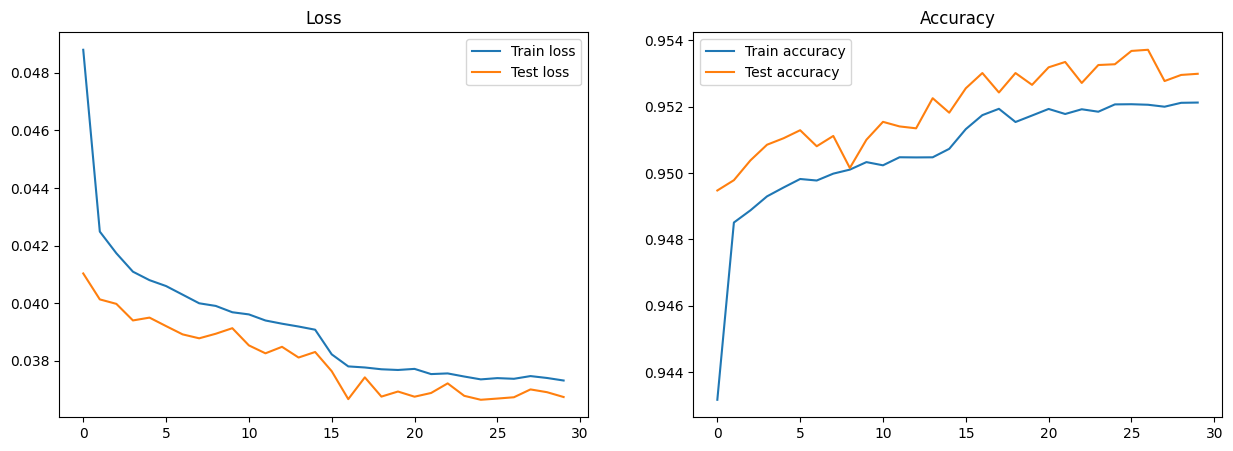

In [ ]:
# ViT-B16 model train & test history plot:
show_history(vit_history)

In [ ]:
# Evaluating the ViT-B16 model:
vit_evaluate = vit_model.evaluate(test_generator,
                                  steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                  verbose = 1)

98/98 [==============================] - 27s 276ms/step - loss: 0.0368 - binary_accuracy: 0.9535 - precision: 0.7359 - recall: 0.3281 - auc: 0.8108


In [ ]:
# Extracting ViT-B16 model metrics:
vit_test_accuracy, vit_test_precision, vit_test_recall, vit_test_auc = vit_evaluate[1:]
vit_test_f1 = 2 * (vit_test_precision * vit_test_recall) / (vit_test_precision + vit_test_recall)

print('ViT-B16 Test Accuracy:', vit_test_accuracy)
print('ViT-B16 Test AUC-score:', vit_test_auc)
print('ViT-B16 Test F1-score:', vit_test_f1)
print('ViT-B16 Test Precision:', vit_test_precision)
print('ViT-B16 Test Recall:', vit_test_recall)

ViT-B16 Test Accuracy: 0.9535413384437561
ViT-B16 Test AUC-score: 0.8107925057411194
ViT-B16 Test F1-score: 0.45387005797005975
ViT-B16 Test Precision: 0.7358738780021667
ViT-B16 Test Recall: 0.328125


### 6.4 Swin-B Transformer:

In [ ]:
# Compiling the Swin-B Transformer model:
swin_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the Swin-B Transformer model:
swin_start_time = time.time()

swin_history = swin_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

swin_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 330s 326ms/step - loss: 0.0517 - binary_accuracy: 0.9391 - precision: 0.4151 - recall: 0.1095 - auc: 0.5781 - val_loss: 0.0441 - val_binary_accuracy: 0.9456 - val_precision: 0.6689 - val_recall: 0.1549 - val_auc: 0.6673 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 274s 313ms/step - loss: 0.0453 - binary_accuracy: 0.9444 - precision: 0.5867 - recall: 0.1582 - auc: 0.6373 - val_loss: 0.0430 - val_binary_accuracy: 0.9468 - val_precision: 0.7398 - val_recall: 0.1547 - val_auc: 0.6863 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 273s 312ms/step - loss: 0.0443 - binary_accuracy: 0.9457 - precision: 0.6154 - recall: 0.1806 - auc: 0.6687 - val_loss: 0.0422 - val_binary_accuracy: 0.9477 - val_precision: 0.7091 - val_recall: 0.1970 - val_auc: 0.6999 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 273s 312ms/step - loss: 0.0438 - binary_accuracy: 0.9463 - precision: 0.6301 - recall

In [ ]:
# Saving the Swin-B Transformer model:
swin_model.save('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-Swin-B.h5')

In [ ]:
# Total time taken to train Swin-B Transformer model:
print("Time taken:", swin_end_time - swin_start_time, "seconds.")

Time taken: 8239.50509095192 seconds.


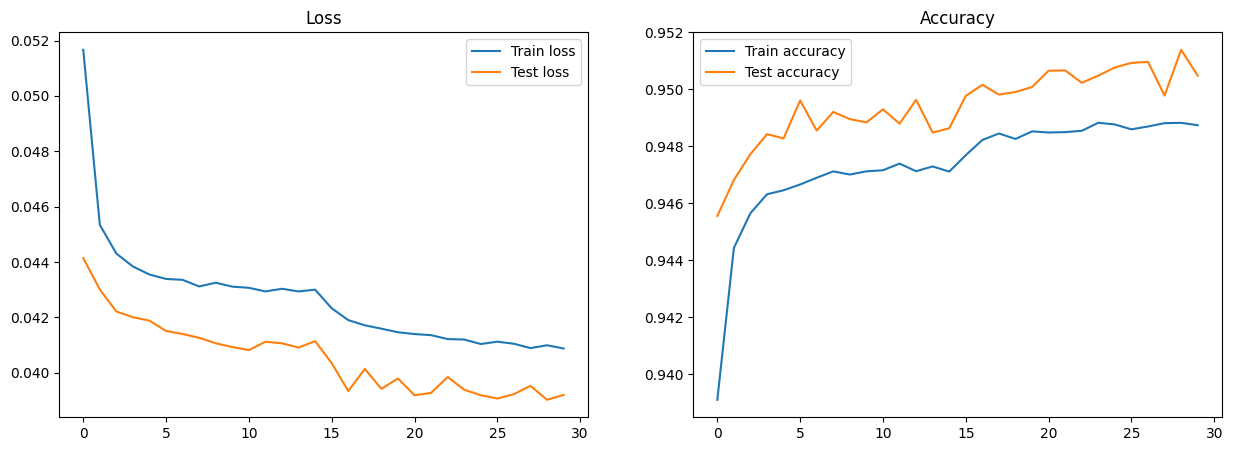

In [ ]:
# Swin-B Transformer model train & test history plot:
show_history(swin_history)

In [ ]:
# Evaluating the Swin-B Transformer model:
swin_evaluate = swin_model.evaluate(test_generator,
                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                    verbose = 1)

98/98 [==============================] - 27s 277ms/step - loss: 0.0389 - binary_accuracy: 0.9516 - precision: 0.7178 - recall: 0.2936 - auc: 0.7642


In [ ]:
# Extracting Swin-B Transformer model metrics:
swin_test_accuracy, swin_test_precision, swin_test_recall, swin_test_auc = swin_evaluate[1:]
swin_test_f1 = 2 * (swin_test_precision * swin_test_recall) / (swin_test_precision + swin_test_recall)

print('Swin-B Transformer Test Accuracy:', swin_test_accuracy)
print('Swin-B Transformer Test AUC-score:', swin_test_auc)
print('Swin-B Transformer Test F1-score:', swin_test_f1)
print('Swin-B Transformer Test Precision:', swin_test_precision)
print('Swin-B Transformer Test Recall:', swin_test_recall)

Swin-B Transformer Test Accuracy: 0.9516456127166748
Swin-B Transformer Test AUC-score: 0.7642138600349426
Swin-B Transformer Test F1-score: 0.4166897742562248
Swin-B Transformer Test Precision: 0.7177650332450867
Swin-B Transformer Test Recall: 0.2935546934604645


### 6.5 Ensemble Model:

#### 6.5.1  Average Ensemble:

In [ ]:
# Compiling the base average ensemble model:
average_ensemble_base_A.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the average ensemble model:
average_base_start_time = time.time()

average_base_history = average_ensemble_base_A.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = 20, # Lower epochs here, in order to cope with overfitting!
    verbose = 1,
    callbacks = callbacks_list)

average_base_end_time = time.time()

Epoch 1/20
874/874 [==============================] - 451s 436ms/step - loss: 0.0311 - binary_accuracy: 0.9579 - precision: 0.7428 - recall: 0.4249 - auc: 0.9127 - val_loss: 0.0377 - val_binary_accuracy: 0.9534 - val_precision: 0.6832 - val_recall: 0.3928 - val_auc: 0.7910 - lr: 0.0010
Epoch 2/20
874/874 [==============================] - 348s 398ms/step - loss: 0.0309 - binary_accuracy: 0.9582 - precision: 0.7384 - recall: 0.4376 - auc: 0.9132 - val_loss: 0.0375 - val_binary_accuracy: 0.9543 - val_precision: 0.7128 - val_recall: 0.3812 - val_auc: 0.7863 - lr: 0.0010
Epoch 3/20
874/874 [==============================] - 348s 398ms/step - loss: 0.0305 - binary_accuracy: 0.9585 - precision: 0.7374 - recall: 0.4475 - auc: 0.9184 - val_loss: 0.0386 - val_binary_accuracy: 0.9538 - val_precision: 0.6937 - val_recall: 0.3911 - val_auc: 0.7898 - lr: 0.0010
Epoch 4/20
874/874 [==============================] - 347s 398ms/step - loss: 0.0302 - binary_accuracy: 0.9589 - precision: 0.7366 - recall

In [ ]:
# Saving the average ensemble model:
average_ensemble_base_A.save('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-Average.h5')

In [ ]:
# Total time taken to train average ensemble model:
print("Time taken:", average_base_end_time - average_base_start_time, "seconds.")

Time taken: 7058.446125507355 seconds.


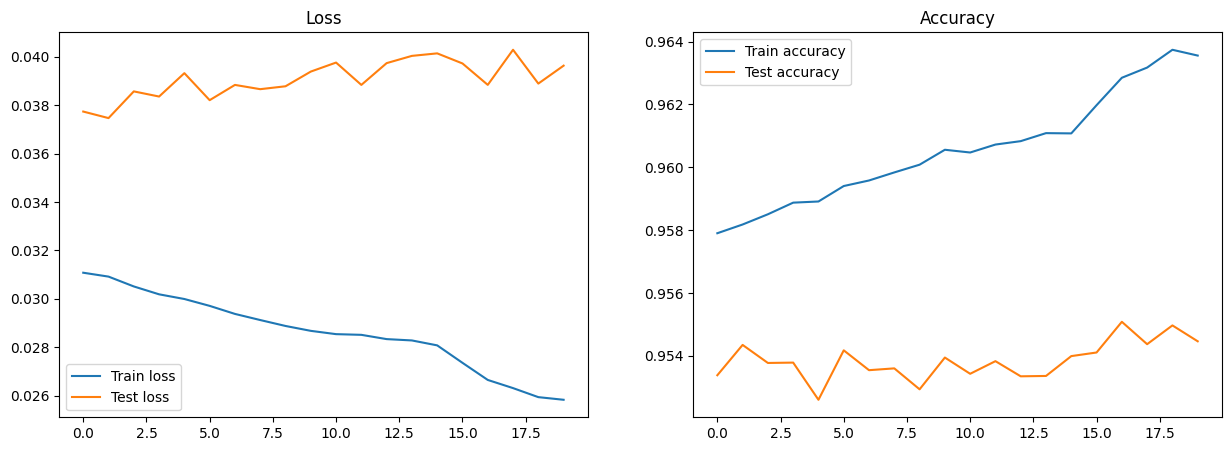

In [ ]:
# Average ensemble model train & test history plot:
show_history(average_base_history)

In [ ]:
# Evaluating the base average ensemble model:
average_base = average_ensemble_base_A.evaluate(test_generator,
                                                steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                verbose = 1)

98/98 [==============================] - 27s 281ms/step - loss: 0.0398 - binary_accuracy: 0.9548 - precision: 0.7021 - recall: 0.4059 - auc: 0.7789


In [ ]:
# Extracting base average ensemble model metrics:
average_base_test_accuracy, average_base_test_precision, average_base_test_recall, average_base_test_auc = average_base[1:]
average_base_test_f1 = 2 * (average_base_test_precision * average_base_test_recall) / (average_base_test_precision + average_base_test_recall)

print('Base Average Ensemble Model Test Accuracy:', average_base_test_accuracy)
print('Base Average Ensemble Model Test AUC-score:', average_base_test_auc)
print('Base Average Ensemble Model Test F1-score:', average_base_test_f1)
print('Base Average Ensemble Model Test Precision:', average_base_test_precision)
print('Base Average Ensemble Model Test Recall:', average_base_test_recall)

Base Average Ensemble Model Test Accuracy: 0.9548057317733765
Base Average Ensemble Model Test AUC-score: 0.778861939907074
Base Average Ensemble Model Test F1-score: 0.5143844935656618
Base Average Ensemble Model Test Precision: 0.7020559310913086
Base Average Ensemble Model Test Recall: 0.40588465332984924


## *7. Fine-tuning & Evaluation:*

In [ ]:
# Defining LearningRateScheduler for fine-tuning:
def fine_scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return 0.00001

fine_lr_scheduler = LearningRateScheduler(fine_scheduler)

In [ ]:
# Defining BackupAndRestore for fine-tuning:
fine_restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/NORMAL/backup',
                                save_freq = 'epoch',
                                delete_checkpoint = True)

In [ ]:
# Creating callback list:
fine_callbacks_list = [fine_restore,
                       fine_lr_scheduler]

### 7.1 EfficientNet-V2M:

In [ ]:
# Unfreezing the EfficientNet-V2M model layers:
for layer in efficientnet_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the EfficientNet-V2M model:
efficientnet_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the EfficientNet_V2M model:
efficientnet_start_time = time.time()

efficientnet_history = efficientnet_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

efficientnet_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 333s 323ms/step - loss: 0.0422 - binary_accuracy: 0.9493 - precision: 0.6702 - recall: 0.2568 - auc: 0.7323 - val_loss: 0.0359 - val_binary_accuracy: 0.9544 - val_precision: 0.7526 - val_recall: 0.3414 - val_auc: 0.8169 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 276s 316ms/step - loss: 0.0350 - binary_accuracy: 0.9557 - precision: 0.7349 - recall: 0.3761 - auc: 0.8441 - val_loss: 0.0337 - val_binary_accuracy: 0.9567 - val_precision: 0.7582 - val_recall: 0.4031 - val_auc: 0.8326 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 277s 317ms/step - loss: 0.0319 - binary_accuracy: 0.9593 - precision: 0.7611 - recall: 0.4407 - auc: 0.8737 - val_loss: 0.0316 - val_binary_accuracy: 0.9603 - val_precision: 0.7806 - val_recall: 0.4484 - val_auc: 0.8444 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 275s 315ms/step - loss: 0.0292 - binary_accuracy: 0.9625 - precision: 0.7

In [ ]:
# Saving the fine-tuned EfficientNet-V2M model:
efficientnet_model.save('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-EfficientNet-V2M.h5')

In [ ]:
# Total time taken to train EfficientNet-V2M model:
print("Time taken:", efficientnet_end_time - efficientnet_start_time, "seconds.")

Time taken: 8330.92322897911 seconds.


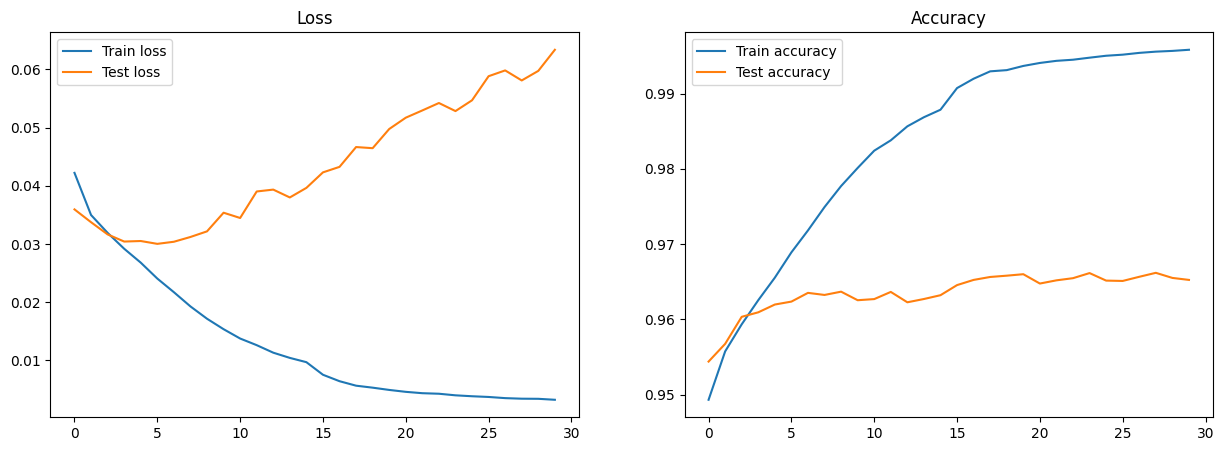

In [ ]:
# EfficientNet_V2M model train & test history plot:
show_history(efficientnet_history)

In [ ]:
# Evaluating the EfficientNet-V2M model:
efficientnet_evaluate = efficientnet_model.evaluate(test_generator,
                                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                    verbose = 1)

98/98 [==============================] - 27s 274ms/step - loss: 0.0613 - binary_accuracy: 0.9663 - precision: 0.7445 - recall: 0.6535 - auc: 0.8538


In [ ]:
# Extracting EfficientNet_V2M model metrics:
efficientnet_test_accuracy, efficientnet_test_precision, efficientnet_test_recall, efficientnet_test_auc = efficientnet_evaluate[1:]
efficientnet_test_f1 = 2 * (efficientnet_test_precision * efficientnet_test_recall) / (efficientnet_test_precision + efficientnet_test_recall)

print('EfficientNet_V2M Test Accuracy:', efficientnet_test_accuracy)
print('EfficientNet_V2M Test AUC-score:', efficientnet_test_auc)
print('EfficientNet_V2M Test F1-score:', efficientnet_test_f1)
print('EfficientNet_V2M Test Precision:', efficientnet_test_precision)
print('EfficientNet_V2M Test Recall:', efficientnet_test_recall)

EfficientNet_V2M Test Accuracy: 0.9663424491882324
EfficientNet_V2M Test AUC-score: 0.8537683486938477
EfficientNet_V2M Test F1-score: 0.6960672577655259
EfficientNet_V2M Test Precision: 0.7445061206817627
EfficientNet_V2M Test Recall: 0.6535463929176331


### 7.2 ConvNeXt-B:

In [ ]:
# Unfreezing the ConvNeXt-B model layers:
for layer in convnext_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the ConvNeXt-B model:
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ConvNeXt-B model:
convnext_start_time = time.time()

convnext_history = convnext_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

convnext_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 323s 339ms/step - loss: 0.0468 - binary_accuracy: 0.9467 - precision: 0.6567 - recall: 0.1784 - auc: 0.6203 - val_loss: 0.0423 - val_binary_accuracy: 0.9488 - val_precision: 0.7215 - val_recall: 0.2198 - val_auc: 0.7120 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 292s 334ms/step - loss: 0.0408 - binary_accuracy: 0.9503 - precision: 0.7141 - recall: 0.2443 - auc: 0.7342 - val_loss: 0.0374 - val_binary_accuracy: 0.9513 - val_precision: 0.7217 - val_recall: 0.2988 - val_auc: 0.7702 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 291s 333ms/step - loss: 0.0371 - binary_accuracy: 0.9536 - precision: 0.7330 - recall: 0.3207 - auc: 0.8037 - val_loss: 0.0353 - val_binary_accuracy: 0.9557 - val_precision: 0.7732 - val_recall: 0.3433 - val_auc: 0.8057 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 289s 331ms/step - loss: 0.0340 - binary_accuracy: 0.9571 - precision: 0.7

In [ ]:
# Saving the fine-tuned ConvNeXt-B model:
convnext_model.save('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ConvNeXt-B.h5')

In [ ]:
# Total time taken to train ConvNeXt-B model:
print("Time taken:", convnext_end_time - convnext_start_time, "seconds.")

Time taken: 8730.759321451187 seconds.


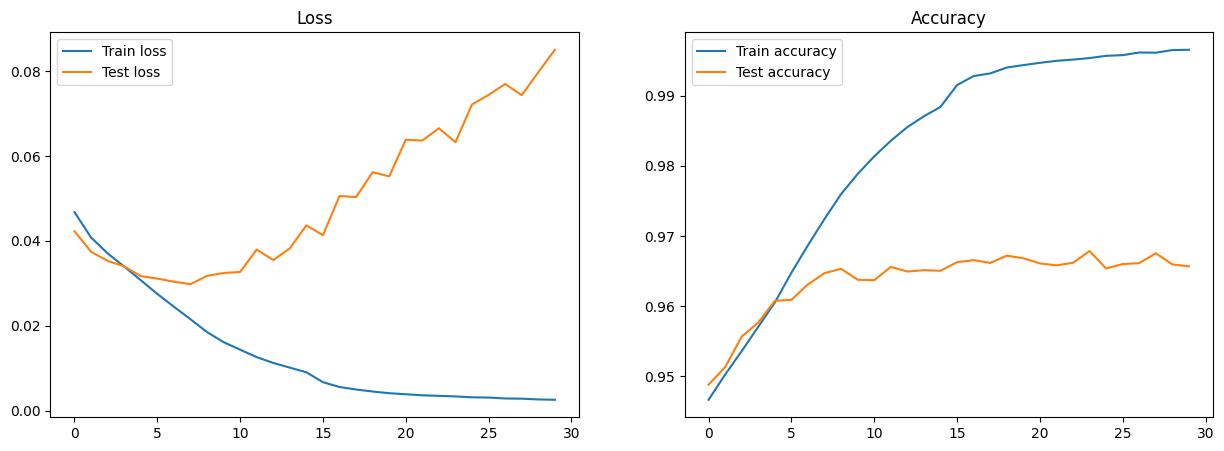

In [ ]:
# ConvNeXt-B model train & test history plot:
show_history(convnext_history)

In [ ]:
# Evaluating the ConvNeXt-B model:
convnext_evaluate = convnext_model.evaluate(test_generator,
                                            steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                            verbose = 1)

98/98 [==============================] - 27s 279ms/step - loss: 0.0796 - binary_accuracy: 0.9669 - precision: 0.7390 - recall: 0.6775 - auc: 0.8494


In [ ]:
# Extracting ConvNeXt-B model metrics:
convnext_test_accuracy, convnext_test_precision, convnext_test_recall, convnext_test_auc = convnext_evaluate[1:]
convnext_test_f1 = 2 * (convnext_test_precision * convnext_test_recall) / (convnext_test_precision + convnext_test_recall)

print('ConvNeXt-B Test Accuracy:', convnext_test_accuracy)
print('ConvNeXt-B Test AUC-score:', convnext_test_auc)
print('ConvNeXt-B Test F1-score:', convnext_test_f1)
print('ConvNeXt-B Test Precision:', convnext_test_precision)
print('ConvNeXt-B Test Recall:', convnext_test_recall)

ConvNeXt-B Test Accuracy: 0.9668713212013245
ConvNeXt-B Test AUC-score: 0.8493953943252563
ConvNeXt-B Test F1-score: 0.7069228403662232
ConvNeXt-B Test Precision: 0.7390010356903076
ConvNeXt-B Test Recall: 0.6775136590003967


### 7.3 ViT-B16:

In [ ]:
# Unfreezing the ViT-B16 model layers:
for layer in vit_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the ViT-B16 model:
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ViT-B16 model:
vit_start_time = time.time()

vit_history = vit_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

vit_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 302s 319ms/step - loss: 0.0362 - binary_accuracy: 0.9542 - precision: 0.7090 - recall: 0.3626 - auc: 0.8376 - val_loss: 0.0323 - val_binary_accuracy: 0.9591 - val_precision: 0.7842 - val_recall: 0.4262 - val_auc: 0.8618 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 274s 313ms/step - loss: 0.0315 - binary_accuracy: 0.9590 - precision: 0.7469 - recall: 0.4472 - auc: 0.8876 - val_loss: 0.0304 - val_binary_accuracy: 0.9600 - val_precision: 0.7572 - val_recall: 0.4836 - val_auc: 0.8712 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 273s 312ms/step - loss: 0.0283 - binary_accuracy: 0.9629 - precision: 0.7752 - recall: 0.5117 - auc: 0.9142 - val_loss: 0.0297 - val_binary_accuracy: 0.9609 - val_precision: 0.7672 - val_recall: 0.4768 - val_auc: 0.8837 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 273s 313ms/step - loss: 0.0255 - binary_accuracy: 0.9662 - precision: 0.7

In [ ]:
# Saving the fine-tuned ViT-B16 model:
vit_model.save('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ViT-B16.h5')

In [ ]:
# Total time taken to train ViT-B16 model:
print("Time taken:", vit_end_time - vit_start_time, "seconds.")

Time taken: 8254.818636655807 seconds.


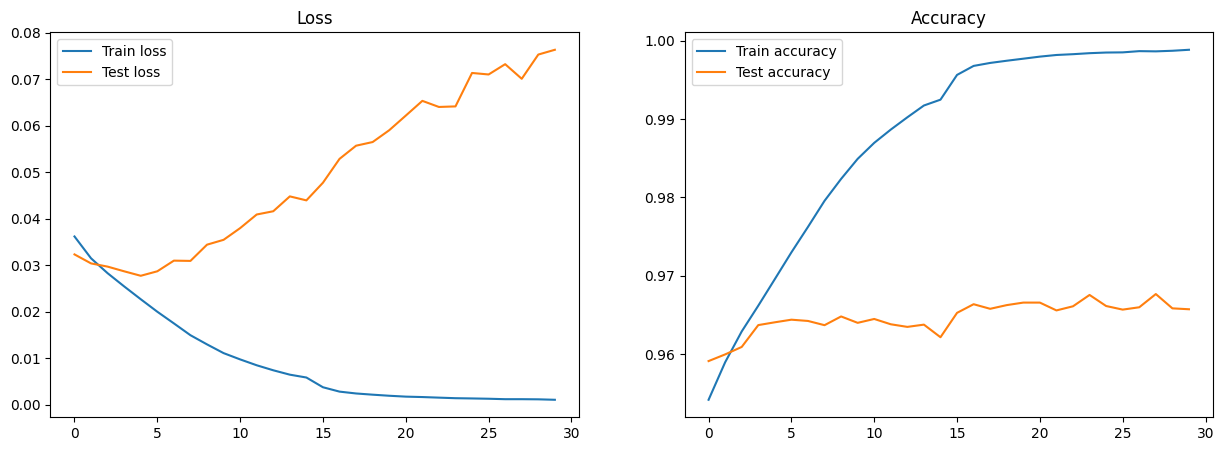

In [ ]:
# ViT-B16 model train & test history plot:
show_history(vit_history)

In [ ]:
# Evaluating the ViT-B16 model:
vit_evaluate = vit_model.evaluate(test_generator,
                                  steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                  verbose = 1)

98/98 [==============================] - 27s 276ms/step - loss: 0.0739 - binary_accuracy: 0.9662 - precision: 0.7290 - recall: 0.6795 - auc: 0.8579


In [ ]:
# Extracting ViT-B16 model metrics:
vit_test_accuracy, vit_test_precision, vit_test_recall, vit_test_auc = vit_evaluate[1:]
vit_test_f1 = 2 * (vit_test_precision * vit_test_recall) / (vit_test_precision + vit_test_recall)

print('ViT-B16 Test Accuracy:', vit_test_accuracy)
print('ViT-B16 Test AUC-score:', vit_test_auc)
print('ViT-B16 Test F1-score:', vit_test_f1)
print('ViT-B16 Test Precision:', vit_test_precision)
print('ViT-B16 Test Recall:', vit_test_recall)

ViT-B16 Test Accuracy: 0.9662045240402222
ViT-B16 Test AUC-score: 0.8579033017158508
ViT-B16 Test F1-score: 0.7033787048608975
ViT-B16 Test Precision: 0.7290403246879578
ViT-B16 Test Recall: 0.679462194442749


###7.4 Swin-B Transformer:

In [ ]:
# Unfreezing the Swin-B Transformer model layers:
for layer in swin_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the Swin-B Transformer model:
swin_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the Swin-B Transformer model:
swin_start_time = time.time()

swin_history = swin_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

swin_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 339s 334ms/step - loss: 0.0440 - binary_accuracy: 0.9479 - precision: 0.6871 - recall: 0.1957 - auc: 0.6746 - val_loss: 0.0416 - val_binary_accuracy: 0.9491 - val_precision: 0.7006 - val_recall: 0.2431 - val_auc: 0.7251 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 279s 319ms/step - loss: 0.0407 - binary_accuracy: 0.9497 - precision: 0.6761 - recall: 0.2615 - auc: 0.7596 - val_loss: 0.0386 - val_binary_accuracy: 0.9502 - val_precision: 0.6982 - val_recall: 0.2911 - val_auc: 0.7633 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 279s 319ms/step - loss: 0.0378 - binary_accuracy: 0.9519 - precision: 0.6917 - recall: 0.3139 - auc: 0.7994 - val_loss: 0.0352 - val_binary_accuracy: 0.9545 - val_precision: 0.7214 - val_recall: 0.3640 - val_auc: 0.8034 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 282s 322ms/step - loss: 0.0354 - binary_accuracy: 0.9543 - precision: 0.7

In [ ]:
# Saving the fine-tuned Swin-B Transformer model:
swin_model.save('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-Swin-B.h5')

In [ ]:
# Total time taken to train Swin-B Transformer model:
print("Time taken:", swin_end_time - swin_start_time, "seconds.")

Time taken: 8439.43566250801 seconds.


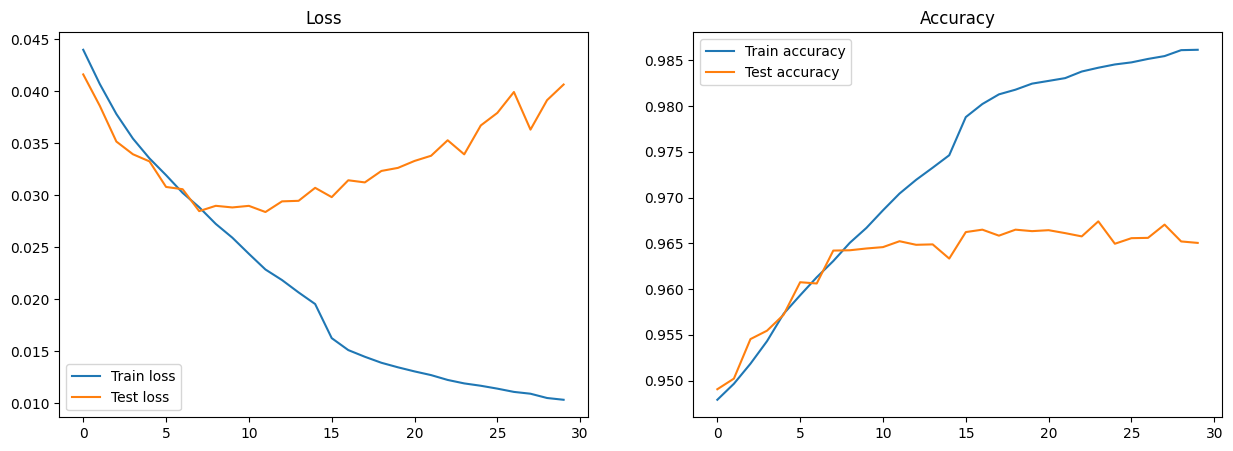

In [ ]:
# Swin-B Transformer model train & test history plot:
show_history(swin_history)

In [ ]:
# Evaluating the Swin-B Transformer model:
swin_evaluate = swin_model.evaluate(test_generator,
                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                    verbose = 1)

98/98 [==============================] - 28s 283ms/step - loss: 0.0387 - binary_accuracy: 0.9659 - precision: 0.7330 - recall: 0.6643 - auc: 0.8682


In [ ]:
# Extracting Swin-B Transformer model metrics:
swin_test_accuracy, swin_test_precision, swin_test_recall, swin_test_auc = swin_evaluate[1:]
swin_test_f1 = 2 * (swin_test_precision * swin_test_recall) / (swin_test_precision + swin_test_recall)

print('Swin-B Transformer Test Accuracy:', swin_test_accuracy)
print('Swin-B Transformer Test AUC-score:', swin_test_auc)
print('Swin-B Transformer Test F1-score:', swin_test_f1)
print('Swin-B Transformer Test Precision:', swin_test_precision)
print('Swin-B Transformer Test Recall:', swin_test_recall)

Swin-B Transformer Test Accuracy: 0.9659287929534912
Swin-B Transformer Test AUC-score: 0.8682181239128113
Swin-B Transformer Test F1-score: 0.6969232188564147
Swin-B Transformer Test Precision: 0.7329606413841248
Swin-B Transformer Test Recall: 0.6642634272575378


### 7.5 Ensemble Model:

#### 7.5.1  Average Ensemble:

In [28]:
# Unfreezing the average ensemble model layers:
for layer in average_ensemble_fine_A.layers:
    layer.trainable = True

In [29]:
# Compiling the average ensemble model:
average_ensemble_fine_A.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the average ensemble model:
average_fine_start_time = time.time()

average_fine_history = average_ensemble_fine_A.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = 20, # Lower epochs here, in order to cope with overfitting!
    verbose = 1,
    callbacks = fine_callbacks_list)

average_fine_end_time = time.time()

Epoch 1/20
874/874 [==============================] - 526s 513ms/step - loss: 0.0023 - binary_accuracy: 0.9974 - precision: 0.9891 - recall: 0.9667 - auc: 0.9997 - val_loss: 0.0537 - val_binary_accuracy: 0.9682 - val_precision: 0.7650 - val_recall: 0.6667 - val_auc: 0.8690 - lr: 1.0000e-04
Epoch 2/20
874/874 [==============================] - 413s 473ms/step - loss: 0.0034 - binary_accuracy: 0.9961 - precision: 0.9806 - recall: 0.9526 - auc: 0.9992 - val_loss: 0.0485 - val_binary_accuracy: 0.9674 - val_precision: 0.7598 - val_recall: 0.6567 - val_auc: 0.8853 - lr: 1.0000e-04
Epoch 3/20
874/874 [==============================] - 411s 471ms/step - loss: 0.0029 - binary_accuracy: 0.9968 - precision: 0.9845 - recall: 0.9607 - auc: 0.9993 - val_loss: 0.0494 - val_binary_accuracy: 0.9679 - val_precision: 0.7517 - val_recall: 0.6839 - val_auc: 0.8693 - lr: 1.0000e-04
Epoch 4/20
874/874 [==============================] - 410s 469ms/step - loss: 0.0025 - binary_accuracy: 0.9972 - precision: 0.9

In [ ]:
# Saving the fine-tuned average ensemble model:
average_ensemble_fine_A.save('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-Average.h5')

In [ ]:
# Total time taken to train average ensemble model:
print("Time taken:", average_fine_end_time - average_fine_start_time, "seconds.")

Time taken: 8344.160165548325 seconds.


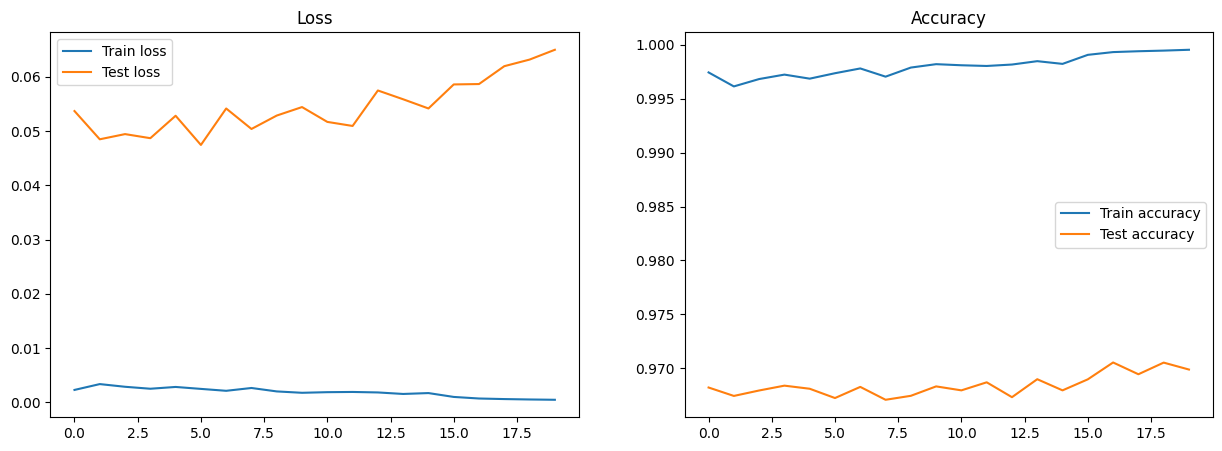

In [ ]:
# Average ensemble model train & test history plot:
show_history(average_fine_history)

In [ ]:
# Evaluating the fine-tuned average ensemble model:
average_fine = average_ensemble_fine_A.evaluate(test_generator,
                                                steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                verbose = 1)

98/98 [==============================] - 27s 279ms/step - loss: 0.0650 - binary_accuracy: 0.9702 - precision: 0.7810 - recall: 0.6873 - auc: 0.8524


In [ ]:
# Extracting fine-tuned average ensemble model metrics:
average_fine_test_accuracy, average_fine_test_precision, average_fine_test_recall, average_fine_test_auc = average_fine[1:]
average_fine_test_f1 = 2 * (average_fine_test_precision * average_fine_test_recall) / (average_fine_test_precision + average_fine_test_recall)

print('Fine-tuned Average Ensemble Model Test Accuracy:', average_fine_test_accuracy)
print('Fine-tuned Average Ensemble Model Test AUC-score:', average_fine_test_auc)
print('Fine-tuned Average Ensemble Model Test F1-score:', average_fine_test_f1)
print('Fine-tuned Average Ensemble Model Test Precision:', average_fine_test_precision)
print('Fine-tuned Average Ensemble Model Test Recall:', average_fine_test_recall)

Fine-tuned Average Ensemble Model Test Accuracy: 0.9701921939849854
Fine-tuned Average Ensemble Model Test AUC-score: 0.852382242679596
Fine-tuned Average Ensemble Model Test F1-score: 0.7311360125720042
Fine-tuned Average Ensemble Model Test Precision: 0.7810009121894836
Fine-tuned Average Ensemble Model Test Recall: 0.6872564554214478


## *8. External Testing:*

### 8.1 EfficientNet-V2M:

In [ ]:
# Submission EfficientNet-V2M base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
efficientnet_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-EfficientNet-V2M.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = efficientnet_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-EfficientNet-V2M.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-EfficientNet-V2M.csv', index = False)

In [ ]:
# Submission EfficientNet-V2M fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
efficientnet_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-EfficientNet-V2M.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = efficientnet_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-EfficientNet-V2M.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-EfficientNet-V2M.csv', index = False)

### 8.2 ConvNeXt-B:

In [ ]:
# Submission ConvNeXt-B base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
convnext_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ConvNeXt-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = convnext_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-ConvNeXt-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-ConvNeXt-B.csv', index = False)

In [ ]:
# Submission ConvNeXt-B fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
convnext_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ConvNeXt-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = convnext_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-ConvNeXt-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-ConvNeXt-B.csv', index = False)

###8.3 ViT-B16

In [ ]:
# Submission ViT-B16 base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
vit_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-ViT-B16.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = vit_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-ViT-B16.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-ViT-B16.csv', index = False)

In [ ]:
# Submission ViT-B16 fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
vit_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-ViT-B16.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = vit_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-ViT-B16.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-ViT-B16.csv', index = False)

###8.4 Swin-B Transformer:

In [ ]:
# Submission Swin-B Transformer base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
swin_model.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-Swin-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = swin_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-Swin-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-Swin-B.csv', index = False)

In [ ]:
# Submission Swin-B Transformer fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
swin_model.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-Swin-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = swin_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-Swin-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-Swin-B.csv', index = False)

###8.5 Ensemble Model:

In [ ]:
# Submission ensemble model base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
average_ensemble_base_A.load_weights('/content/drive/MyDrive/MODELS-A/BASE/BASE-NOAUG-Average.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = average_ensemble_base_A.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-Average.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-NOAUG-Average.csv', index = False)

In [ ]:
# Submission ensemble model fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
average_ensemble_fine_A.load_weights('/content/drive/MyDrive/MODELS-A/FINETUNED/FINE-NOAUG-Average.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = average_ensemble_fine_A.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-Average.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-NOAUG-Average.csv', index = False)

## REFERENCES:

* *Loading data & pre-processing:* https://www.kaggle.com/code/mathormad/inceptionv3-baseline-lb-0-379